### Predict the Discount Codes for a Purchasable Item

A new e-commerce app is going live. To provide offers to different segments of customers they have tied up with different vendors and banking partners. Now they have a lots of data but don’t know how to provide the correct offers to the correct customers. You have to predict the columns Coupon Code and Payment Code.
  
#### Data
Data Files  
Train.csv: 8009 x 19 : contains training data  
Test.csv: 6218 x 17 : contains test data  
Submission format.csv: 6218 x 3 : expected results file containing predictions for test data  

#### Data Description

| Columns | Description |
| :--- | :--- |
| customer_id | unique Customer id |
| seller_id | type of gift (clothes/perfumes/etc.) |
| order_checkout_date | category to which the gift belongs under that gift type |
| delivery_eta | Estimated delivery date |
| shipping_charges | approximate shipping charges to deliver the product based on location |
| product_category_code | The categorical code for the product |
| X_1, X_2 | anonymized columns |
| Product_quality_type | segment of the product based on its quality, for ex: in shoes there maybe, local brand there maybe Nike/Adidas |
| Product_mass | weight of the product |
| Product_length, product_height, product_breadth | dimensions of the product |
| Payment_emi_years(max) | EMI tenure max. available if someone opts for |
| Transaction_type | the type of transaction done for the order |
| Order_status | the status of the order, E = executed successfully, A = Alternate product order later, N = Not Available and cancelled, R = Replacement ordered, H = Address not found and returned |
| Coupon_code | The coupon code that should be recommended to the customer based on the product (Electronics (ELEC), Clothing (CLOTH), etc.) |
| Payment_code | The payment code based on the mode of payment that the customer prefers to use mostly. (Google Play (GPAY), Card Payment (HSBC/HDFC) |
	
#### Evaluation Criteria
The evaluation metric will be the mean of the weighted avg. of the recall score generated for both the y-variables 

\begin{equation}
score1 = 100*recall\_score(actual\_values['payment\_code'], predicted\_values['payment\_code'], average ='weighted') \\ score2 = 100*recall\_score(actual\_values['coupon\_code'], predicted\_values['coupon\_code'], average ='weighted')\\ score = (score1+score2)/2
\end{equation}

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import metrics
from sklearn import preprocessing
import category_encoders as ce
import pickle
import datetime

In [2]:
train = pd.read_csv('Data\Train.csv', index_col=0)
train.head()

,seller_id,order_checkout_date,delivery_eta,shipping_charges,product_category_code,X_1,X_2,product_quality_type,product_mass,product_length,product_height,product_breadth,payment_emi_years(max),price,order_status,transaction_type,coupon_code,payment_code
customer_id,,,,,,,,,,,,,,,,,,
0a29abf475fb8039d2775913d6f0b6f0,48436dade18ac8b2bce089ec2a041202,2017-08-05 16:59:05,2017-09-06 00:00:00,18.12,27.0,58.0,598.0,D,650,28,9,14,1.0,153.75,E,1,CLOTH20,GPAY20
903ac1be571f2dc655f9083ffc936ce6,5b51032eddd242adc84c38acab88f23d,2017-10-30 15:35:32,2017-11-24 00:00:00,20.08,55.0,59.0,695.0,B,3050,33,13,33,1.0,388.17,E,3,CLOTH20,CITI10
bfadadd0d97f4c52f859c1c4d809edf9,4a3ca9315b744ce9f8e9374361493884,2017-11-04 12:03:25,2017-11-30 00:00:00,2.29,14.0,54.0,245.0,A,1383,50,10,40,1.0,216.72,E,1,CLOTH20,GPAY20
6c9e6937792cc04d9bb23451e0ff9f48,4a3ca9315b744ce9f8e9374361493884,2017-06-15 11:46:47,2017-07-10 00:00:00,1.86,14.0,54.0,245.0,A,1383,50,10,40,1.0,228.95,E,1,CLOTH15,CITI10
906e77e04c502baf17ad58162217da39,4a3ca9315b744ce9f8e9374361493884,2018-01-03 09:14:25,2018-01-31 00:00:00,15.57,14.0,54.0,245.0,A,1383,50,10,40,1.0,243.51,E,2,CLOTH15,CITI10


#### Categorical Columns Analysis

Data Size: 8009
Categorical Columns Number of Unique Values

Sellers: 504 

product_category_code: 75


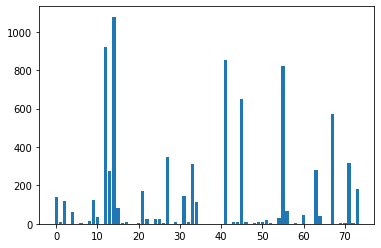

product_quality_type: 12


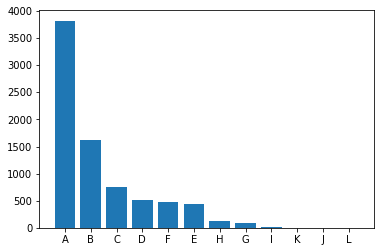

order_status: 5


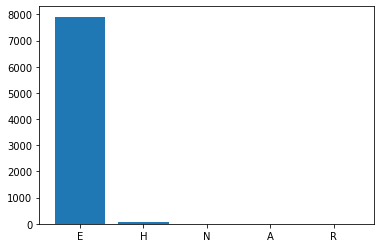

transaction_type: 15


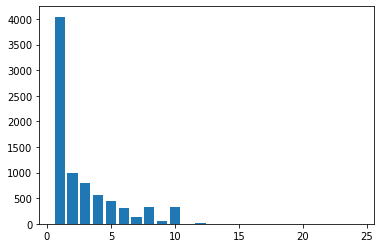

In [3]:
print('Data Size:', len(train))
print('Categorical Columns Number of Unique Values\n')
print('Sellers:', len(np.unique(train['seller_id'])), '\n')

print('product_category_code:', len(np.unique(train['product_category_code'])))
plt.bar(train['product_category_code'].value_counts().keys(), train['product_category_code'].value_counts().values)
plt.show()

print('product_quality_type:', len(train['product_quality_type'].value_counts()))
plt.bar(train['product_quality_type'].value_counts().keys(), train['product_quality_type'].value_counts().values)
plt.show()

print('order_status:', len(train['order_status'].value_counts()))
plt.bar(train['order_status'].value_counts().keys(), train['order_status'].value_counts().values)
plt.show()

print('transaction_type:', len(np.unique(train['transaction_type'])))
plt.bar(train['transaction_type'].value_counts().keys(), train['transaction_type'].value_counts().values)
plt.show()

#### X_1 and X_2 Analysis

In [4]:
print('X_1 Uniques:', len(np.unique(train['X_1'])))
# plt.plot(train['X_1'])
# plt.show()
# plt.hist(train['X_1'])
# plt.show()

print('X_2 Uniques:', len(np.unique(train['X_2'])))
# plt.plot(train['X_2'])
# plt.show()
# plt.hist(train['X_2'])
# plt.show()

X_1 Uniques: 188
X_2 Uniques: 863


- Too many values to treat as categorical
- Takes only integer values
- Most probably counts of some type
- Treat as numeric

#### Handling NaN 

In [5]:
print('Number of rows with atleast 1 NaN:', sum(train.isna().any(axis=1)))
print('Percentage of rows with atleast 1 NaN:', round(sum(train.isna().any(axis=1))/len(train)*100, 2))
print('Columns with NaNs:\n', list(train.columns[train.isna().any(axis=0)]))
print('Number of NaNs')
print('shipping_charges:', sum(train['shipping_charges'].isna()))
print('product_category_code:', sum(train['product_category_code'].isna()))
print('X_1:', sum(train['X_1'].isna()))
print('X_2:', sum(train['X_2'].isna()))
print('product_quality_type:', sum(train['product_quality_type'].isna()))
print('payment_emi_years(max):', sum(train['payment_emi_years(max)'].isna()))
print('price:', sum(train['price'].isna()))
print('Common NaNs in X_1, X_2 and Product Quality:', sum(train[['X_1', 'X_2', 'product_quality_type']].isna().any(axis=1)))
print('Common NaNs in others:', sum(train[['X_1', 'X_2', 'product_quality_type', 'price', 'product_category_code']].isna().all(axis=1)))

Number of rows with atleast 1 NaN: 199
Percentage of rows with atleast 1 NaN: 2.48
Columns with NaNs:
 ['shipping_charges', 'product_category_code', 'X_1', 'X_2', 'product_quality_type', 'payment_emi_years(max)', 'price']
Number of NaNs
shipping_charges: 14
product_category_code: 23
X_1: 138
X_2: 138
product_quality_type: 138
payment_emi_years(max): 15
price: 10
Common NaNs in X_1, X_2 and Product Quality: 138
Common NaNs in others: 0


In [6]:
train[['shipping_charges', 'payment_emi_years(max)']] = train[['shipping_charges', 'payment_emi_years(max)']].fillna(0)
train.dropna(inplace=True)

#### Output Column 1

coupon_code: 7


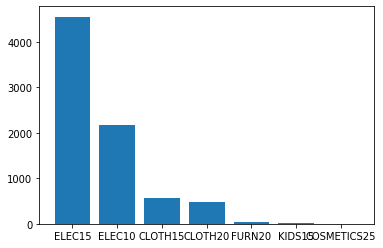

In [7]:
print('coupon_code:', len(train['coupon_code'].value_counts()))
plt.bar(train['coupon_code'].value_counts().keys(), train['coupon_code'].value_counts().values)
plt.show()

payment_code: 5


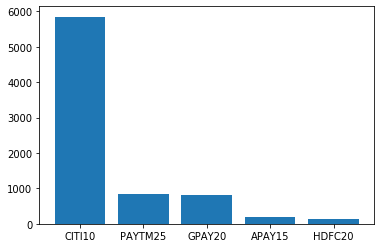

In [8]:
print('payment_code:', len(train['payment_code'].value_counts()))
plt.bar(train['payment_code'].value_counts().keys(), train['payment_code'].value_counts().values)
plt.show()

In [9]:
def test_chi2(col1, col2, showTable=False):
    print(col1, 'vs', col2)
    print('------------------------------------', end='')
    data_crosstab = pd.crosstab(train[col1], train[col2])
    if showTable:
        print(data_crosstab)
    chi2, p, dof, ex = stats.chi2_contingency(data_crosstab)
    if p<0.01:
        print('\nNot independent')
    else:
        print('\nMight be independent')
    I = metrics.mutual_info_score(train[col1], train[col2])
    H1 = stats.entropy(train[col1].value_counts())
    H2 = stats.entropy(train[col2].value_counts())
    print('Scaled Mutual Information:', round(I/(H1+H2), 4))

In [10]:
test_chi2('payment_code', 'coupon_code', True)

payment_code vs coupon_code
------------------------------------coupon_code   CLOTH15  CLOTH20  COSMETICS25  ELEC10  ELEC15  FURN20  KIDS15
payment_code                                                               
APAY15             10        7            0      79      86       2       0
CITI10            431      375            3    1558    3420      36      23
GPAY20             42       42            1     223     511       5       3
HDFC20             13       10            0      40      73       1       0
PAYTM25            68       39            1     267     463       5       2

Not independent
Scaled Mutual Information: 0.0016


In [11]:
for col in ['product_category_code', 'product_quality_type', 'order_status', 'transaction_type']:
    test_chi2(col, 'coupon_code')
    print(' ')

product_category_code vs coupon_code
------------------------------------
Not independent
Scaled Mutual Information: 0.0178
 
product_quality_type vs coupon_code
------------------------------------
Not independent
Scaled Mutual Information: 0.0059
 
order_status vs coupon_code
------------------------------------
Might be independent
Scaled Mutual Information: 0.0011
 
transaction_type vs coupon_code
------------------------------------
Not independent
Scaled Mutual Information: 0.0142
 


In [12]:
for col in ['product_category_code', 'product_quality_type', 'order_status', 'transaction_type']:
    test_chi2(col, 'payment_code')
    print(' ')

product_category_code vs payment_code
------------------------------------
Not independent
Scaled Mutual Information: 0.0048
 
product_quality_type vs payment_code
------------------------------------
Might be independent
Scaled Mutual Information: 0.0011
 
order_status vs payment_code
------------------------------------
Might be independent
Scaled Mutual Information: 0.0012
 
transaction_type vs payment_code
------------------------------------
Not independent
Scaled Mutual Information: 0.0852
 


### Feature Engineering

#### Encondings
- High Dimensionality
  - One Hot
- Loss of Info
  - Binary Encoding
  - Hashing
- Overfitting
  - Frequency Encoding
  - Target Encoding
  - Weight of Evidence (Adjusted if needed)
  - Probability Ratio Encoding
  - James Stein
  - M-Estimator

In [13]:
leCoupon = preprocessing.LabelEncoder()
lePayment = preprocessing.LabelEncoder()

train['coupon_code_enc'] = leCoupon.fit_transform(train['coupon_code'])
train['payment_code_enc'] = lePayment.fit_transform(train['payment_code'])

couponNames = train['coupon_code'].value_counts().keys()
couponKeys = leCoupon.transform(couponNames)
couponDict = dict(zip(couponKeys, couponNames))

paymentNames = train['payment_code'].value_counts().keys()
paymentKeys = lePayment.transform(paymentNames)
paymentDict = dict(zip(paymentKeys, paymentNames))

outputEnc = preprocessing.OneHotEncoder()
outCols = outputEnc.fit_transform(train[['coupon_code_enc', 'payment_code_enc']]).toarray()

for i in range(outCols.shape[1]):
    col = outputEnc.get_feature_names()[i] 
    if col[1] == '0':
        train['Coupon:' + couponDict[int(col[3])]] = outCols[:, i]
    else:
        train['Payment:' + paymentDict[int(col[3])]] = outCols[:, i]

train.drop(['coupon_code', 'coupon_code_enc', 'payment_code', 'payment_code_enc'], axis=1, inplace=True)
outColNames = [col for col in train.columns if ':' in col]

In [14]:
reference_date = datetime.datetime.now()

train['delivery_eta'] = train['delivery_eta'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
train['order_checkout_date'] = train['order_checkout_date'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
train['wait-time'] = (train['delivery_eta'] - train['order_checkout_date']).apply(lambda x: x.total_seconds()/3600)
train['delivery_eta'] = train['delivery_eta'].apply(lambda x:(reference_date-x).total_seconds()/3600)
train['order_checkout_date'] = train['order_checkout_date'].apply(lambda x:(reference_date-x).total_seconds()/3600)

In [15]:
train['volume'] = train['product_height']*train['product_length']*train['product_breadth']
train['product_density'] = train['product_mass']/train['volume']
train['price_per_g'] = train['price']/train['product_mass']
train['price_per_vol'] = train['price']/train['volume']
qualityEnc = preprocessing.LabelEncoder()
train['product_quality_type'] = 12-qualityEnc.fit_transform(train['product_quality_type'])
train.head()

,seller_id,order_checkout_date,delivery_eta,shipping_charges,product_category_code,X_1,X_2,product_quality_type,product_mass,product_length,...,Payment:APAY15,Payment:CITI10,Payment:GPAY20,Payment:HDFC20,Payment:PAYTM25,wait-time,volume,product_density,price_per_g,price_per_vol
customer_id,,,,,,,,,,,,,,,,,,,,,
0a29abf475fb8039d2775913d6f0b6f0,48436dade18ac8b2bce089ec2a041202,28371.215326,27620.200049,18.12,27.0,58.0,598.0,9,650,28,...,0.0,0.0,1.0,0.0,0.0,751.015278,3528,0.184240,0.236538,0.043580
903ac1be571f2dc655f9083ffc936ce6,5b51032eddd242adc84c38acab88f23d,26308.607826,25724.200049,20.08,55.0,59.0,695.0,11,3050,33,...,0.0,1.0,0.0,0.0,0.0,584.407778,14157,0.215441,0.127269,0.027419
bfadadd0d97f4c52f859c1c4d809edf9,4a3ca9315b744ce9f8e9374361493884,26192.143104,25580.200049,2.29,14.0,54.0,245.0,12,1383,50,...,0.0,0.0,1.0,0.0,0.0,611.943056,20000,0.069150,0.156703,0.010836
6c9e6937792cc04d9bb23451e0ff9f48,4a3ca9315b744ce9f8e9374361493884,29600.420326,29012.200049,1.86,14.0,54.0,245.0,12,1383,50,...,0.0,1.0,0.0,0.0,0.0,588.220278,20000,0.069150,0.165546,0.011447
906e77e04c502baf17ad58162217da39,4a3ca9315b744ce9f8e9374361493884,24754.959771,24092.200049,15.57,14.0,54.0,245.0,12,1383,50,...,0.0,1.0,0.0,0.0,0.0,662.759722,20000,0.069150,0.176074,0.012175


In [16]:
catCols = ['seller_id', 'product_category_code', 'order_status', 'transaction_type']
data = train.copy()

#### Frequency Encoding

In [17]:
trainFreq = data.copy()

In [18]:
def freqEnc(df, feature):
    freq = df.groupby(feature).size()/len(df)
    df[feature] = df[feature].map(freq)

In [19]:
for catCol in catCols:
    freqEnc(trainFreq, catCol)
pickle.dump(trainFreq, open('Data\\trainFreq.sav', 'wb'))

#### Target Encoding

In [20]:
targEncs = {}
trainTarg = data.copy()

for outCol in outColNames:
    targEnc = ce.target_encoder.TargetEncoder(cols=catCols)
    targEnc.fit(trainTarg[catCols], trainTarg[outCol])
    trainTarg[[col + ':' + outCol for col in catCols]] = targEnc.transform(trainTarg[catCols])
    targEncs[outCol] = targEnc
    
trainTarg.drop(catCols, axis=1, inplace=True)
pickle.dump(trainTarg, open('Data\\trainTarg.sav', 'wb'))

#### Weight of Evidence

In [21]:
woeEncs = {}
trainWoe = data.copy()

for outCol in outColNames:
    woeEnc = ce.woe.WOEEncoder(cols=catCols)
    woeEnc.fit(trainWoe[catCols], trainWoe[outCol])
    trainWoe[[col + ':' + outCol for col in catCols]] = woeEnc.transform(trainWoe[catCols])
    woeEncs[outCol] = woeEnc
    
trainWoe.drop(catCols, axis=1, inplace=True)
pickle.dump(trainWoe, open('Data\\trainWoe.sav', 'wb'))

#### James Stein Encoder

In [22]:
jsEncs = {}
trainJs = data.copy()

for outCol in outColNames:
    jsEnc = ce.james_stein.JamesSteinEncoder(cols=catCols)
    jsEnc.fit(trainJs[catCols], trainJs[outCol])
    trainJs[[col + ':' + outCol for col in catCols]] = jsEnc.transform(trainJs[catCols])
    jsEncs[outCol] = jsEnc
    
trainJs.drop(catCols, axis=1, inplace=True)
pickle.dump(trainJs, open('Data\\trainJs.sav', 'wb'))

#### M-Estimate Encoder

In [23]:
meEncs = {}
trainMe = data.copy()

for outCol in outColNames:
    meEnc = ce.m_estimate.MEstimateEncoder(cols=catCols)
    meEnc.fit(trainMe[catCols], trainMe[outCol])
    trainMe[[col + ':' + outCol for col in catCols]] = meEnc.transform(trainMe[catCols])
    meEncs[outCol] = meEnc
    
trainMe.drop(catCols, axis=1, inplace=True)
pickle.dump(trainMe, open('Data\\trainMe.sav', 'wb'))